In [62]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [63]:
def load_proton_a_images(n=None):
    data = pd.read_pickle('../data/proton_images2a.pkl')
    return data[:n]

def load_neutron_a_images(n=None):
    data = pd.read_pickle('../data/neutron_images2a.pkl')
    return data[:n]

def load_particle_data_a(n=None):
    data = pd.read_pickle('../data/particles_cond_with_mass2a.pkl')
    return data[:n]

In [64]:
N_SAMPLES = None
data_p = load_proton_a_images(N_SAMPLES)
print('Loaded Proton: ',  data_p.shape)

data_n = load_neutron_a_images(N_SAMPLES)
print('Loaded Neutron: ',  data_n.shape)

data_cond = load_particle_data_a(N_SAMPLES)
print('Loaded cond: ',  data_cond.shape)

Loaded Proton:  (175636, 56, 30)
Loaded Neutron:  (175636, 44, 44)
Loaded cond:  (175636, 11)


## Calculate Sum Photons

In [65]:
data_cond.rename(columns={"PhotonSum": "neutron_photon_sum"}, inplace=True)

In [66]:
data_cond.neutron_photon_sum = data_cond.neutron_photon_sum.astype(float)

In [67]:
data_cond['proton_photon_sum'] = np.sum(data_p, axis=(1,2))

In [68]:
data_cond.head()

,Pdg,Energy,Vx,Vy,Vz,Px,Py,Pz,neutron_photon_sum,mass,charge,proton_photon_sum
0,22,513.318,1.454300e-08,3.650510e-08,-0.002731,0.035456,-0.051821,-513.318,291.0,0.000000,0.0,0.0
1,22,1304.340,-1.831820e-05,1.555780e-05,0.050293,-0.509192,0.461106,1304.340,8.0,0.000000,0.0,9.0
2,22,1014.720,-1.831820e-05,1.555780e-05,0.050293,-0.335473,0.256277,1014.720,130.0,0.000000,0.0,0.0
3,-211,325.158,0.000000e+00,0.000000e+00,0.000000,0.269915,-0.081921,325.157,0.0,139.570610,-1.0,5.0
4,2112,3192.380,0.000000e+00,0.000000e+00,0.000000,0.022422,-0.182957,-3192.380,1256.0,939.565413,0.0,16.0


## Filter Photon Sum

(15611, 56, 30) (15611, 44, 44) (15611, 12)


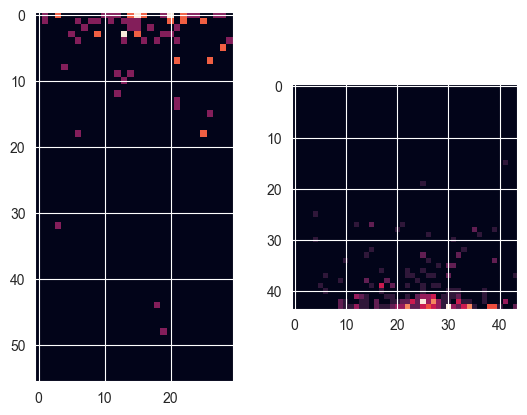

In [72]:
## Filter Photon Sum
def filter_photon_sum(data_p, data_n, data_conditional, min_photon_sum=10):
    """
    Returns particle data and responses of experiments with minimum sum of photons.
    """
    mask = (data_conditional.proton_photon_sum >= min_photon_sum) & (data_conditional.neutron_photon_sum >= min_photon_sum)
    indecies = data_conditional.index[mask]
    return data_p[indecies], data_n[indecies], data_conditional.iloc[indecies].reset_index(drop=True)

MIN_PHOTON_SUM = 15

data_p, data_n, data_cond = filter_photon_sum(data_p, data_n, data_cond, min_photon_sum=MIN_PHOTON_SUM)
print(data_p.shape, data_n.shape, data_cond.shape)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(data_p[3], interpolation='none')
ax[1].imshow(data_n[3], interpolation='none')

## Add padding

Two sizes of images:
- 56 x 30
- 44 x 44

__Goal:__ Add padding to images to transform them to common size: 56 x 44

__Approaches:__
- add padding around the images (center the content)
- add padding to one side of images

In [20]:
from enum import Enum

class PaddingMethod(Enum):
    CENTER = 0
    LEFT_SIDE = 0

In [21]:
def add_padding_56_30(image, method: PaddingMethod = PaddingMethod.CENTER.name):
    """
    Transform image of shape(56, 30) into shape(56, 44).
    :param method: Method of adding padding
    :param image: Image of shape(56, 30)
    :returns: Image of shape(56, 44)
    """
    if method == PaddingMethod.CENTER.name:
        # Add 7 pixels to the left and right side of image
        return np.pad(image,
                      pad_width=((0, 0), (7, 7)),
                      mode='constant', constant_values=0)


def add_padding_44_44(image, method: PaddingMethod = PaddingMethod.CENTER.name):
    """
    Transform image of shape(44, 44) into shape(56, 44).
    :param method: Method of adding padding
    :param image: Image of shape(44, 44)
    :returns: Image of shape(56, 44)
    """
    if method == PaddingMethod.CENTER.name:
        # Add 7 pixels to the top and bottom side of image
        return np.pad(image,
                      pad_width=((6, 6), (0, 0)),
                      mode='constant', constant_values=0)

In [22]:
padded_p = np.array(list(map(add_padding_56_30, data_p)))

In [23]:
padded_n = np.array(list(map(add_padding_44_44, data_n)))

In [38]:
padded_p.shape, padded_n.shape

((15611, 56, 44), (15611, 56, 44))

## Combine images into two channels

Given the padded images, combine them into a single image with 2 channels

In [40]:
def combine_into_channels(data_1, data_2):
    return np.dstack((data_1, data_2))

In [41]:
data = combine_into_channels(padded_p, padded_n)

In [42]:
data.shape

(15611, 56, 88)

### Output combained image is

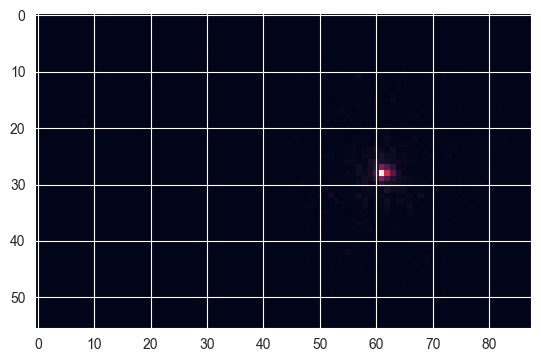

In [51]:
plt.imshow(data[0], interpolation='none')

And the original, separate images

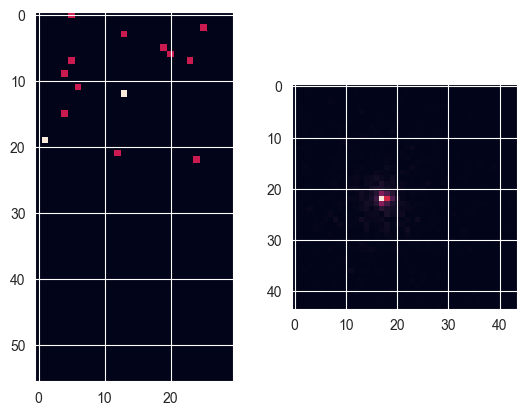

In [55]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(data_p[0], interpolation='none')
ax[1].imshow(data_n[0], interpolation='none')

Even though in the combined image the proton response is barely visible, the from combined image and separate images is equal.

In [59]:
assert data[0].sum() == (data_p[0].sum() + data_n[0].sum())

In [30]:
data = np.concatenate((padded_p, padded_n), axis=1)
data = data.reshape(-1, 56, 44, 2)

(<matplotlib.image.AxesImage at 0x1afaa9defa0>, 130.0)

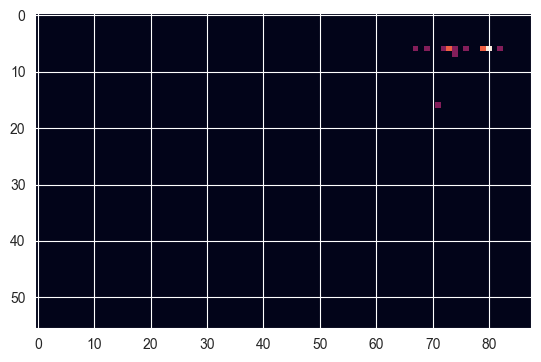

In [64]:
plt.imshow(data[23], interpolation='none'), data[2].sum()

## Save files

In [70]:
data_cond.to_pickle(f"../data/data_cond_photonsum_{MIN_PHOTON_SUM}.pkl")

In [75]:
with open(f"../data/data_proton_neutron_photonsum_{MIN_PHOTON_SUM}_padding.pkl", 'wb') as f:
    pickle.dump(data, f)